In [1]:
! pip install geopandas pandas sqlalchemy psycopg2-binary openpyxl geoalchemy2 python-dotenv

/bin/bash: /media/mutakabbir/HDD_2TB_02/Forest_Fire/.venv/bin/pip: /media/mutakabbir/HDD_2TB_01/Forest_Fire/.venv/bin/python: bad interpreter: No such file or directory


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine

import os
from dotenv import load_dotenv

In [2]:
PATH_TO_DOT_ENV = "../../.env"

DATABASE_TYPE = "postgresql"
DATABASE_HOST = "localhost"

CNFDB_TABLE_NAME = "F"
CANADIAN_SUBDIVISON_TABLE_NAME = "S_c"

SUBDIVISION_TABLE_NAME = "S"

In [4]:
load_dotenv(PATH_TO_DOT_ENV)

DATABASE_NAME = os.environ.get("DATABASE_NAME")
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_HOST_PORT = os.environ.get("POSTGRES_HOST_PORT")
POSTGRES_CONTAINER_PORT = os.environ.get("POSTGRES_CONTAINER_PORT")

In [5]:
engine = create_engine(f"{DATABASE_TYPE}://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DATABASE_HOST}:{POSTGRES_HOST_PORT}/{DATABASE_NAME}")

In [16]:
query_avg_area = f"""
select 
    avg(st_area(sc.geometry)) as avg_area 
from 
    "{CANADIAN_SUBDIVISON_TABLE_NAME}" sc
"""


# Query to cluster that gemotry of the data such that there are "num_of_clusters" with max raduis = "avg_r"
query_clusted_subdiv = lambda avg_r, num_of_clusters: f"""
select
    sc.geometry ,
    ST_ClusterKMeans(
        sc.geometry ,
        {num_of_clusters},                      
        max_radius := {avg_r}    -- but generate more to make each under avg_radius km radius
    ) over () as cid
from
    "{CANADIAN_SUBDIVISON_TABLE_NAME}" sc ;
"""


## Cluster small division close by based on distance

In [8]:
avg_area_df = pd.read_sql(query_avg_area, con=engine)
avg_area_df

,avg_area
0,4.986018


In [9]:
num_of_clusters = 13
avg_area = avg_area_df['avg_area'].values[0]
avg_distance = np.sqrt(avg_area/3.14)
avg_distance

1.2601205556886532

<Axes: >

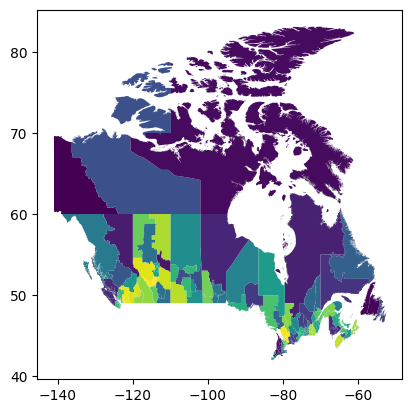

In [30]:
# cluster the data with into "num_of_clusters" (13) clusters where max radius of the cluster is "avg_distance"
cluter_subdivision_gdf = gpd.read_postgis(
    sql=query_clusted_subdiv(avg_distance, num_of_clusters), 
    con=engine, 
    geom_col="geometry", 
    crs="EPSG:4326"
)
cluter_subdivision_gdf.plot(
    column = "cid"
)

In [11]:
# cluter_subdivision_gdf.plot(
#     figsize=(20,20),
#     column="cid",
#     cmap="RdYlBu",
#     legend=True
# )

In [31]:
# merge the mearest boundaries into one cluster by disloving them 
merged_subdivision_gdf = cluter_subdivision_gdf.dissolve('cid')

In [32]:
del cluter_subdivision_gdf

In [17]:
%%time
merged_subdivision_gdf.to_postgis(name=SUBDIVISION_TABLE_NAME, con=engine, if_exists='replace', index=True)  

CPU times: user 15.7 s, sys: 1.38 s, total: 17.1 s
Wall time: 25.1 s


In [37]:
merged_subdivision_gdf['area'] = merged_subdivision_gdf.to_crs("EPSG:3857").area # convert to m^2
merged_subdivision_gdf['area'] = merged_subdivision_gdf['area'] / 100000 # convert to hectares

<Axes: >

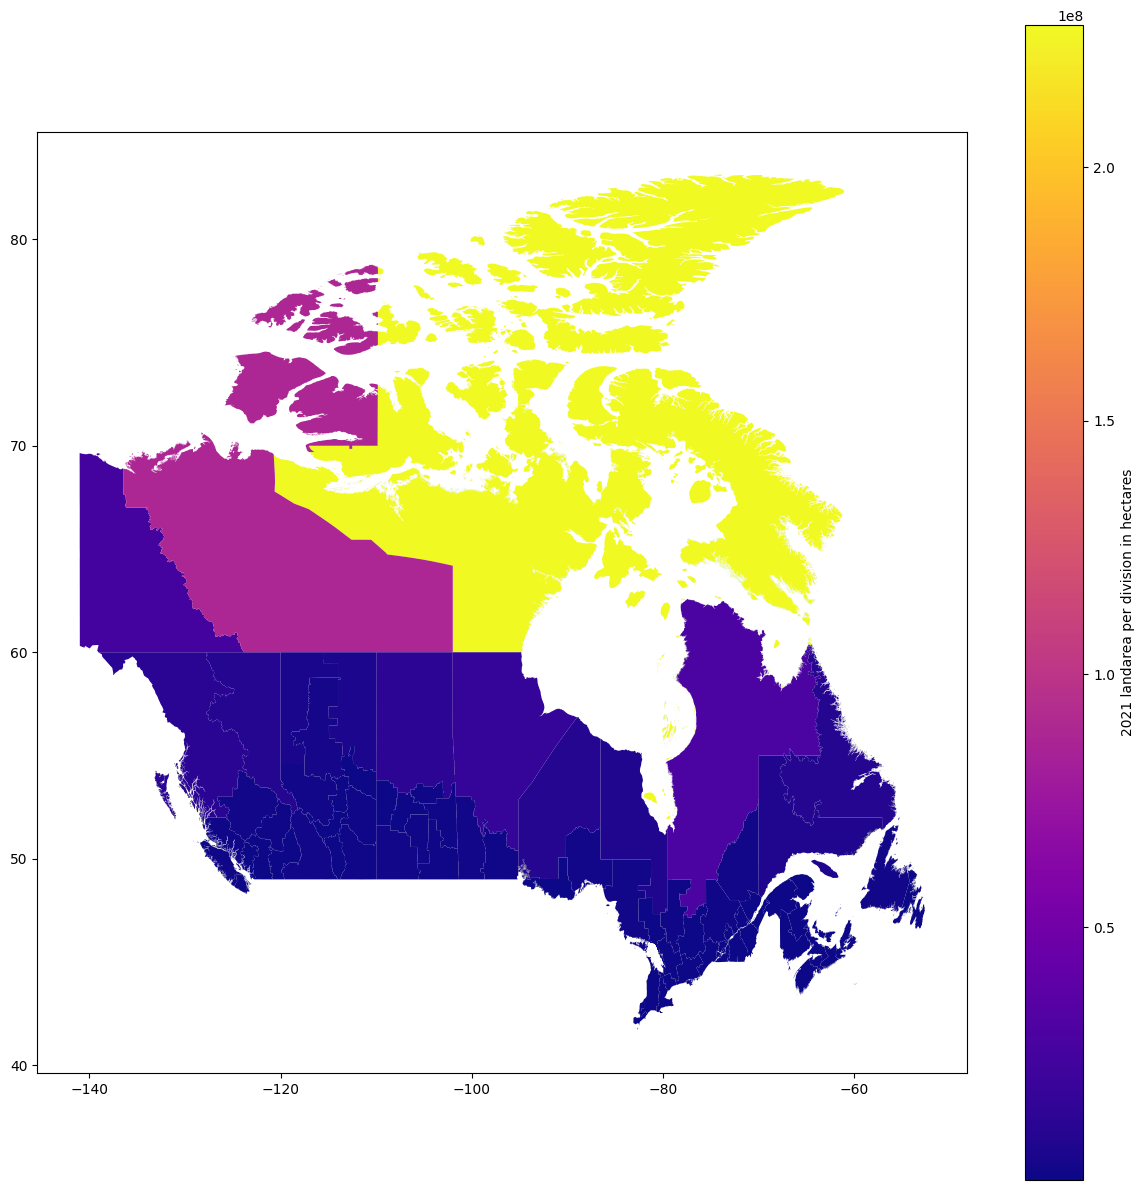

In [39]:
merged_subdivision_gdf.plot(
    figsize=(15,15),
    column = "area",
    cmap='plasma',
    legend = True,
    legend_kwds={"label": "2021 landarea per division in hectares", "orientation": "vertical"}
)